## Ames Housing Sale Price Prediction - Feature Selection

In [55]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=Warning)
warnings.filterwarnings("ignore", category=FutureWarning)

import matplotlib.pyplot as plt
%matplotlib inline

pd.pandas.set_option('display.max_columns', None)

In [56]:
data = pd.read_csv('Ames_train_FE.csv')
data.shape

(1460, 84)

## Hybrid method: Recursive feature elimination

This method consists of the following steps:

1) Rank the features according to their importance derived from a machine learning algorithm: it can be tree importance, or LASSO / Ridge, or the linear / logistic regression coefficients.

2) Remove one feature -the least important- and build a machine learning algorithm utilising the remaining features.

3) Calculate a performance metric of your choice: roc-auc, mse, rmse, accuracy.

4) If the metric decreases by more of an arbitrarily set threshold, then that feature is important and should be kept. Otherwise, we can remove that feature.

5) Repeat steps 2-4 until all features have been removed (and therefore evaluated) and the drop in performance assessed.


I call this a hybrid method because:

- it combines the importance derived from the machine learning algorithm like embedded methods,
- and it removes as well one feature at a time, and calculates a new metric based on the new subset of features and the machine learning algorithm of choice, like wrapper methods.

The difference between this method and the step backwards feature selection we learned in previous lectures lies in that it does not remove all features first in order to determine which one to remove. It removes the least important one, based on the machine learning model derived important. And then, it makes an assessment as to whether that feature should be removed or not. So it removes each feature only once during selection, whereas step backward feature selection removes all the features at each step of selection.

This method is therefore faster than wrapper methods and generally better than embedded methods. In practice it works extremely well. It does also account for correlations (depending on how stringent you set the arbitrary performance drop threshold). On the downside, the drop in performance assessed to decide whether the feature should be kept or removed, is set arbitrarily. The smaller the drop the more features will be selected, and vice versa.

I will demonstrate how to select features using this method on a regression and classification problem. For classification I will use the Paribas claims dataset from Kaggle. For regression, the House Price dataset from Kaggle.

**Note** For the demonstration, I will use XGBoost, but this method is useful for any machine learning algorithm. In fact, the importance of the features are determined specifically for the algorithm used. Therefore, different algorithms may return different subsets of important features.


In [57]:
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, r2_score

In [58]:
data.head()

,Id,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,LotFrontage_nan,MasVnrArea_nan,GarageYrBlt_nan
0,1,12.247694,0.235294,0.75,0.418208,0.366344,1.0,1.0,0.000000,0.333333,1.0,0.00,0.0,0.636364,0.4,1.0,0.75,1.0,0.666667,0.500,0.036765,0.098361,0.0,0.0,1.0,1.0,0.50,0.12250,0.666667,1.0,1.00,0.75,0.75,0.25,1.000000,0.125089,0.833333,0.0,0.064212,0.140098,1.0,1.00,1.0,1.0,0.356155,0.413559,0.0,0.577712,0.333333,0.0,0.666667,0.5,0.375,0.333333,0.666667,0.500000,1.0,0.000000,0.2,0.8,0.046729,0.666667,0.50,0.386460,0.666667,1.0,1.0,0.000000,0.111517,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.090909,0.50,0.666667,0.75,0.0,0.0,0.0
1,2,12.109011,0.000000,0.75,0.495064,0.391317,1.0,1.0,0.000000,0.333333,1.0,0.50,0.0,0.500000,0.2,1.0,0.75,0.6,0.555556,0.875,0.227941,0.524590,0.0,0.0,0.4,0.3,0.25,0.00000,0.333333,1.0,0.50,0.75,0.75,1.00,0.666667,0.173281,0.833333,0.0,0.121575,0.206547,1.0,1.00,1.0,1.0,0.503056,0.000000,0.0,0.470245,0.000000,0.5,0.666667,0.0,0.375,0.333333,0.333333,0.333333,1.0,0.333333,0.6,0.8,0.289720,0.666667,0.50,0.324401,0.666667,1.0,1.0,0.347725,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.363636,0.25,0.666667,0.75,0.0,0.0,0.0
2,3,12.317167,0.235294,0.75,0.434909,0.422359,1.0,1.0,0.333333,0.333333,1.0,0.00,0.0,0.636364,0.4,1.0,0.75,1.0,0.666667,0.500,0.051471,0.114754,0.0,0.0,1.0,1.0,0.50,0.10125,0.666667,1.0,1.00,0.75,0.75,0.50,1.000000,0.086109,0.833333,0.0,0.185788,0.150573,1.0,1.00,1.0,1.0,0.383441,0.419370,0.0,0.593095,0.333333,0.0,0.666667,0.5,0.375,0.333333,0.666667,0.333333,1.0,0.333333,0.6,0.8,0.065421,0.666667,0.50,0.428773,0.666667,1.0,1.0,0.000000,0.076782,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.727273,0.50,0.666667,0.75,0.0,0.0,0.0
3,4,11.849398,0.294118,0.75,0.388581,0.390295,1.0,1.0,0.333333,0.333333,1.0,0.25,0.0,0.727273,0.4,1.0,0.75,1.0,0.666667,0.500,0.669118,0.606557,0.0,0.0,0.2,0.4,0.25,0.00000,0.333333,1.0,0.25,0.50,1.00,0.25,0.666667,0.038271,0.833333,0.0,0.231164,0.123732,1.0,0.75,1.0,1.0,0.399941,0.366102,0.0,0.579157,0.333333,0.0,0.333333,0.0,0.375,0.333333,0.666667,0.416667,1.0,0.333333,0.8,0.4,0.074766,0.333333,0.75,0.452750,0.666667,1.0,1.0,0.000000,0.063985,0.492754,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.090909,0.00,0.666667,0.00,0.0,0.0,0.0
4,5,12.429216,0.235294,0.75,0.513123,0.468761,1.0,1.0,0.333333,0.333333,1.0,0.50,0.0,1.000000,0.4,1.0,0.75,1.0,0.777778,0.500,0.058824,0.147541,0.0,0.0,1.0,1.0,0.50,0.21875,0.666667,1.0,1.00,0.75,0.75,0.75,1.000000,0.116052,0.833333,0.0,0.209760,0.187398,1.0,1.00,1.0,1.0,0.466237,0.509927,0.0,0.666523,0.333333,0.0,0.666667,0.5,0.500,0.333333,0.666667,0.583333,1.0,0.333333,0.6,0.8,0.074766,0.666667,0.75,0.589563,0.666667,1.0,1.0,0.224037,0.153565,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.000000,0.50,0.666667,0.75,0.0,0.0,0.0


In [59]:
nan_feature = [feature for feature in data.columns if '_nan' in feature]
nan_feature

['LotFrontage_nan', 'MasVnrArea_nan', 'GarageYrBlt_nan']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Id','SalePrice'] + nan_feature, axis=1), data['SalePrice'], 
                                                                        test_size=0.2, random_state=1 )
X_train.shape, X_test.shape

((1168, 79), (292, 79))

In [61]:
# the first step of this procedure  consists in building
# a machine learning algorithm using all the available features
# and then determine the importance of the features according
# to the algorithm

np.random.seed(1)

model_all_features = xgb.XGBRegressor(n_thread=10, max_depth=4, n_estimators=500, learning_rate=0.05)
model_all_features.fit(X_train, y_train)

[21:53:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, n_thread=10, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [62]:
y_pred_test = model_all_features.predict(X_test)
r2_score_all = r2_score(y_test, y_pred_test)
print('Test all features xgb R2: %f' %r2_score_all)

Test all features xgb R2: 0.908641


In [63]:
r2_score_base = r2_score_all

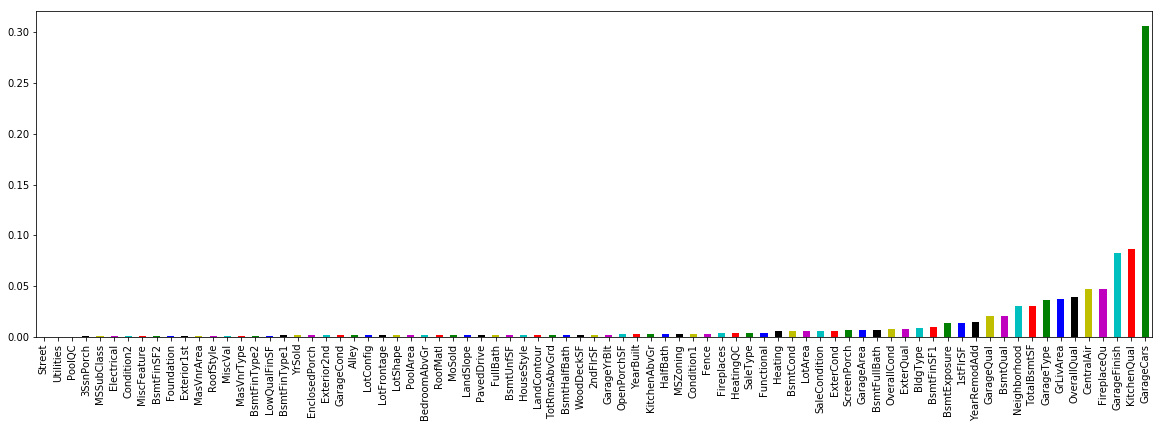

In [64]:
# the second step consist of deriving the importance of 
# each feature and ranking them from the least to the most
# important

features = pd.Series(model_all_features.feature_importances_)
features.index = X_train.columns

features.sort_values(inplace=True, ascending=True)
features.plot.bar(figsize=(20,6), color = list('rgbkymc'))

In [65]:
#features = list(features.index)
features

Street           0.000000
Utilities        0.000000
PoolQC           0.000000
3SsnPorch        0.000400
MSSubClass       0.000506
Electrical       0.000757
Condition2       0.000764
MiscFeature      0.000818
BsmtFinSF2       0.000973
Foundation       0.001066
Exterior1st      0.001091
MasVnrArea       0.001115
RoofStyle        0.001143
MiscVal          0.001196
MasVnrType       0.001242
BsmtFinType2     0.001286
LowQualFinSF     0.001287
BsmtFinType1     0.001311
YrSold           0.001333
EnclosedPorch    0.001346
Exterior2nd      0.001380
GarageCond       0.001404
Alley            0.001405
LotConfig        0.001449
LotFrontage      0.001533
LotShape         0.001553
PoolArea         0.001576
BedroomAbvGr     0.001593
RoofMatl         0.001700
MoSold           0.001724
                   ...   
HeatingQC        0.003958
SaleType         0.004110
Functional       0.004142
Heating          0.005668
BsmtCond         0.005673
LotArea          0.005895
SaleCondition    0.005956
ExterCond   

In [66]:
#let's take top 10 features and try to build a model and see r2

top10_features = features.index[-10:]
top10_features

Index(['Neighborhood', 'TotalBsmtSF', 'GarageType', 'GrLivArea', 'OverallQual',
       'CentralAir', 'FireplaceQu', 'GarageFinish', 'KitchenQual',
       'GarageCars'],
      dtype='object')

In [67]:
model_top10 = xgb.XGBRegressor(n_thread=10, max_depth=4, n_estimators=500, learning_rate=0.05)
model_top10.fit(X_train[top10_features], y_train)

model_top10_pred = model_top10.predict(X_test[top10_features])
r2_top10_model = r2_score(y_test, model_top10_pred)

print('R2 score for top 10 features: %f' %r2_top10_model)

[21:53:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2 score for top 10 features: 0.859877


In [68]:
# the final step consists in removing one at a time
# all the features, from the least to the most
# important, and build an xgboost at each round.

# once we build the model, we calculate the new r2
# if the new r2 is smaller than the original one
# (with all the features), then that feature that was removed
# was important, and we should keep it.
# otherwise, we should remove the feature

# recursive feature elimination:

# first we arbitrarily set the drop in r2
# if the drop is below this threshold,
# the feature will be removed
threshold = 0.01

print('Doing recursive feature elimination')

# we initialise a list where we will collect the
# features we should remove
features_to_remove = []

# set a counter to know how far ahead the loop is going
count = 0

for feature in features.index:
    print('--' * 40)
    count += 1
    print('Testing feature: {} which is feature {} of {}'.format(feature, count, len(features)))
    
    #initialize the model
    model = xgb.XGBRegressor(n_thread=10, max_depth=4, n_estimators=500, learning_rate=0.05)
    
    #fit the model 
    model.fit(X_train.drop(features_to_remove + [feature], axis=1), y_train)
    
    #make prediction over test
    y_test_pred = model.predict(X_test.drop(features_to_remove + [feature], axis=1))
    
    #get r2 score
    r2_model = r2_score(y_test_pred, y_test)
    print('New r2 score: %f and all feature r2 score: %f' %(r2_model, r2_score_all))
          
    diff_r2 = r2_score_all - r2_model
    print('Drop in r2: %f' %diff_r2)
    
    #if r2 falls more than threshold, that feature is important and must be retained
    if diff_r2 > threshold: 
        print('Retain: %s' %feature)
    else:
        print('Drop: %s' %feature)
        features_to_remove.append(feature)
        # if the drop in the r2 is small and we remove the
        # feature, we need to set the new r2 to the one based on
        # the remaining features
        r2_score_all = r2_model
        
print('-*' * 40)
print('Done!!!')

print('Total features to remove: %d' %len(features_to_remove))

features_to_keep = [feature for feature in features.index if feature not in features_to_remove]
print('Total features retained: %d' %len(features_to_keep)) 
print('-*' * 40)
print('Retained Features: ')
print(features_to_keep)


Doing recursive feature elimination
--------------------------------------------------------------------------------
Testing feature: Street which is feature 1 of 79
[21:53:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
New r2 score: 0.891892 and all feature r2 score: 0.908641
Drop in r2: 0.016749
Retain: Street
--------------------------------------------------------------------------------
Testing feature: Utilities which is feature 2 of 79
[21:53:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
New r2 score: 0.891892 and all feature r2 score: 0.908641
Drop in r2: 0.016749
Retain: Utilities
--------------------------------------------------------------------------------
Testing feature: PoolQC which is feature 3 of 79
[21:53:59] WARNING: C:/Jenkins/workspace/xgboost-win

New r2 score: 0.891855 and all feature r2 score: 0.908641
Drop in r2: 0.016786
Retain: Exterior2nd
--------------------------------------------------------------------------------
Testing feature: GarageCond which is feature 22 of 79
[21:56:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
New r2 score: 0.890475 and all feature r2 score: 0.908641
Drop in r2: 0.018166
Retain: GarageCond
--------------------------------------------------------------------------------
Testing feature: Alley which is feature 23 of 79
[21:56:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
New r2 score: 0.894285 and all feature r2 score: 0.908641
Drop in r2: 0.014355
Retain: Alley
--------------------------------------------------------------------------------
Testing feature: LotConfig which is 

New r2 score: 0.901532 and all feature r2 score: 0.898215
Drop in r2: -0.003317
Drop: OpenPorchSF
--------------------------------------------------------------------------------
Testing feature: YearBuilt which is feature 43 of 79
[21:58:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
New r2 score: 0.897980 and all feature r2 score: 0.901532
Drop in r2: 0.003552
Drop: YearBuilt
--------------------------------------------------------------------------------
Testing feature: KitchenAbvGr which is feature 44 of 79
[21:58:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
New r2 score: 0.895435 and all feature r2 score: 0.897980
Drop in r2: 0.002544
Drop: KitchenAbvGr
--------------------------------------------------------------------------------
Testing feature: HalfBath whi

New r2 score: 0.886934 and all feature r2 score: 0.887863
Drop in r2: 0.000929
Drop: BldgType
--------------------------------------------------------------------------------
Testing feature: BsmtFinSF1 which is feature 64 of 79
[21:59:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
New r2 score: 0.893375 and all feature r2 score: 0.886934
Drop in r2: -0.006441
Drop: BsmtFinSF1
--------------------------------------------------------------------------------
Testing feature: BsmtExposure which is feature 65 of 79
[21:59:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
New r2 score: 0.894595 and all feature r2 score: 0.893375
Drop in r2: -0.001220
Drop: BsmtExposure
--------------------------------------------------------------------------------
Testing feature: 1stFlrSF whi

In [69]:
#lets build the final model and see the r2

final_xgb = xgb.XGBRegressor(n_thread=10, max_depth=4, n_estimators=500, learning_rate=0.05)
final_xgb.fit(X_train[features_to_keep], y_train)
final_xgb_pred = final_xgb.predict(X_test[features_to_keep])
final_r2 = r2_score(y_test, final_xgb_pred)

print('Final model r2 score: %f vs. the all feature model r2 score: %f' %(final_r2, r2_score_base))

[22:01:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Final model r2 score: 0.894614 vs. the all feature model r2 score: 0.908641


- 79 Features R2: 0.91
- <b>Threshold 0.01 retains 30 features and gives R2: 0.89</b>
- Threshold 0.02 retains only 4 features and gives R2: 0.86
- Threshold 0.015 retains 17 features that give a R2: 0.82


In [74]:
X1 = pd.concat([y_train, X_train], axis=1)
X1.shape

(1168, 80)

In [75]:
X2 = pd.concat([y_test, X_test], axis=1)
X2.shape

(292, 80)

In [76]:
X_Final = pd.concat([X1, X2], axis=0)
X_Final.shape

(1460, 80)

In [77]:
X_Final.head()

,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
921,11.890677,0.411765,0.75,0.429425,0.373775,1.0,1.0,0.000000,0.333333,1.0,0.0,0.0,0.227273,0.2,1.0,0.50,0.2,0.444444,0.750,0.794118,0.098361,0.0,0.0,0.4,0.3,0.25,0.0000,0.333333,1.0,0.50,0.50,0.75,0.25,0.666667,0.192062,0.833333,0.0,0.080479,0.208183,1.0,0.75,1.0,1.000000,0.506043,0.449395,0.0,0.666845,0.666667,0.0,0.666667,1.0,0.500,0.666667,0.333333,0.583333,1.0,0.000000,0.2,0.0,0.261682,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.127971,0.000000,0.000000,0.0,0.0,0.0,0.75,1.0,0.0,0.727273,0.50,0.666667,0.75
520,11.573550,1.000000,0.75,0.388581,0.414369,1.0,0.0,0.000000,0.333333,1.0,0.0,0.0,0.181818,0.4,1.0,0.00,1.0,0.333333,0.750,0.794118,0.147541,0.0,0.0,0.4,0.3,0.25,0.0000,0.333333,1.0,0.25,0.00,0.25,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0,0.50,0.0,0.666667,0.276760,0.290557,0.0,0.479103,0.000000,0.0,0.666667,0.0,0.375,0.666667,0.333333,0.416667,1.0,0.000000,0.2,0.0,0.261682,0.0,0.0,0.000000,0.000000,0.0,0.0,0.256709,0.208410,0.380435,0.000000,0.0,0.0,0.0,1.00,1.0,0.0,0.636364,0.50,0.666667,0.75
401,12.013640,0.000000,0.75,0.418208,0.373552,1.0,1.0,0.333333,0.333333,1.0,0.0,0.0,0.636364,0.4,1.0,0.75,0.6,0.666667,0.500,0.007353,0.032787,0.0,0.0,1.0,1.0,0.25,0.0000,0.666667,1.0,1.00,0.75,0.75,0.75,1.000000,0.004252,0.833333,0.0,0.550514,0.214403,1.0,1.00,1.0,1.000000,0.517183,0.000000,0.0,0.483450,0.000000,0.0,0.666667,0.0,0.375,0.333333,0.666667,0.333333,1.0,0.333333,0.8,0.8,0.009346,1.0,0.5,0.282087,0.666667,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.00,1.0,0.0,0.545455,0.00,1.000000,1.00
280,12.339291,0.235294,0.75,0.504203,0.423001,1.0,1.0,0.000000,0.333333,1.0,0.0,0.0,0.454545,0.4,1.0,0.75,1.0,0.666667,0.625,0.132353,0.311475,0.0,0.0,0.7,0.7,0.50,0.2125,0.666667,1.0,0.50,0.75,0.75,0.75,1.000000,0.074592,0.833333,0.0,0.165240,0.132079,1.0,0.75,1.0,1.000000,0.476025,0.390799,0.0,0.629930,0.000000,0.0,0.666667,0.5,0.375,0.333333,0.666667,0.416667,1.0,0.333333,0.6,0.8,0.168224,1.0,0.5,0.405501,0.666667,1.0,1.0,0.000000,0.153565,0.000000,0.385827,0.0,0.0,0.0,1.00,1.0,0.0,0.000000,0.25,0.666667,0.75
1401,12.170445,0.235294,0.75,0.400718,0.340771,1.0,1.0,0.333333,0.333333,1.0,0.0,0.0,0.590909,0.4,1.0,0.75,1.0,0.555556,0.500,0.029412,0.081967,0.0,0.0,1.0,1.0,0.25,0.0000,0.333333,1.0,1.00,0.50,0.75,0.25,1.000000,0.134479,0.833333,0.0,0.034247,0.137316,1.0,1.00,1.0,1.000000,0.359675,0.353027,0.0,0.552640,0.333333,0.0,0.666667,0.5,0.375,0.333333,0.333333,0.500000,1.0,0.333333,0.6,0.8,0.037383,1.0,0.5,0.280677,0.666667,1.0,1.0,0.116686,0.137112,0.000000,0.000000,0.0,0.0,0.0,1.00,1.0,0.0,0.272727,0.50,0.666667,0.75


In [78]:
X_Final.to_csv('Ames_train_FS2.csv')